In [1]:
from utils import ImageLoader
import numpy as np
from numpy.fft import fft

# import cv2 as cv
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.rcParams.update(
    {
        # "font.size": 14,
        # "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": "Computer Modern Roman",
    }
)

# Low Res Image MTF


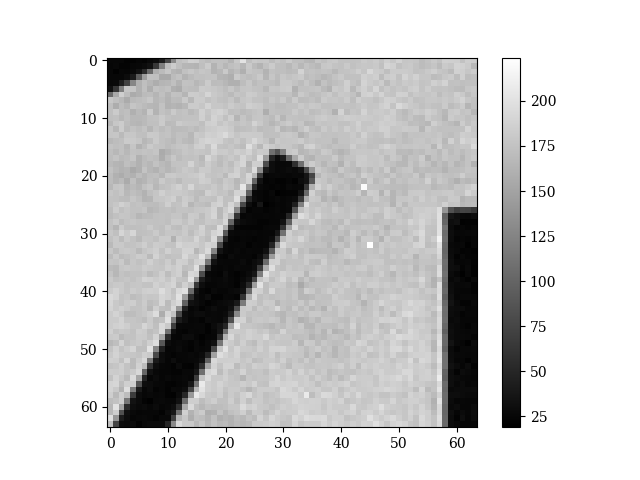

In [205]:
%matplotlib widget
plt.close()


N = 49
# Dot matrix slanted edge
# start = 0
# basePath = "../Dataset/7x7 Dot Matrix/Slanted Edge"
# bitDepth = 10

# Panel matrix slanted Edge
start = 16
basePath = "../Dataset/7x7 Panel Matrix/Slanted Edge 15x15"
bitDepth = 10

# ======================================
imageFNs = [basePath + "/" +
            ('0'*(4-len(str(i+start))) + str(i+start) + '.tiff') for i in range(N)]

# Initialize image loader
# Loader = ImageLoader(imageFNs[0], 64, ROI=(550, 577)) #dot matrix
Loader = ImageLoader(imageFNs[0], 64, ROI=(510, 575))   # panel matrix

sampleImg = Loader.load_image(imageFNs[0])
plt.imshow(sampleImg, cmap='gray')
plt.colorbar()

## 1. Obtain Edge Spread Function (ESF)

### Obtain ROI

corner point [450,400]
ROI [103:123,84:74]


In [206]:
# Dot matrix point
# x0 = 169
# y0 = 100

# Panel matrix point
x0 = 20
y0 = 30

N = 15


x = np.round(np.arange(x0, N+x0)*2) - 20
y = np.int8(-0.4 * np.arange(0, 3*N,3)) + y0
print(x)
print(y)

[20 22 24 26 28 30 32 34 36 38 40 42 44 46 48]
[30 29 28 27 26 24 23 22 21 20 18 17 16 15 14]


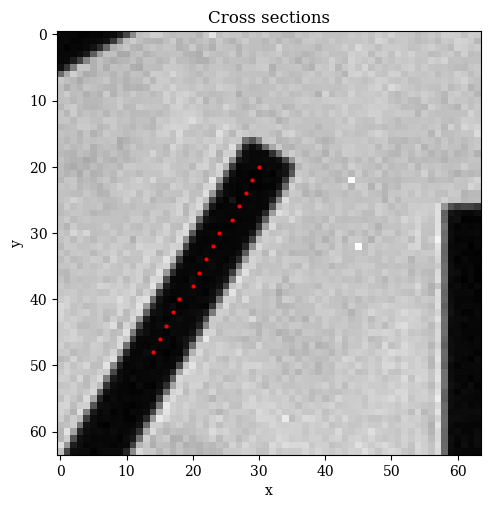

In [207]:
%matplotlib inline
plt.close()

plt.imshow(sampleImg, cmap='gray')
plt.tight_layout()
plt.xlabel('x'); plt.ylabel('y')
plt.plot(y,x,'ro',markersize=2)
plt.title('Cross sections')
plt.show()

### Image Scale

**4x Magnification 0.10 NA**

1px:2.51um


In [208]:
# Obtain real-world units
width = 15
scale = 2.46  # in microns/px
# distances of samples in microns
d = np.linspace(0, width * scale, width, endpoint=False)
d.shape

(15,)

177.0

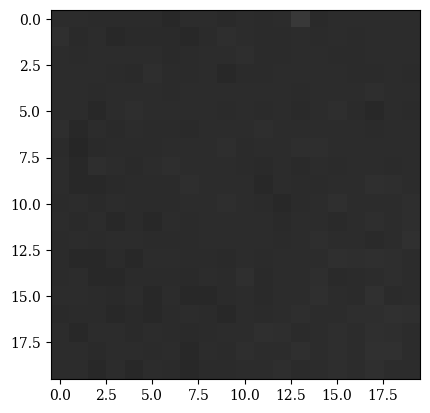

In [209]:
%matplotlib inline
plt.close()
bgPatch = sampleImg[32:52,32:52]
plt.imshow(bgPatch,cmap='gray',vmin=0,vmax=1024)
bgAve = np.round(np.average(bgPatch))
bgAve

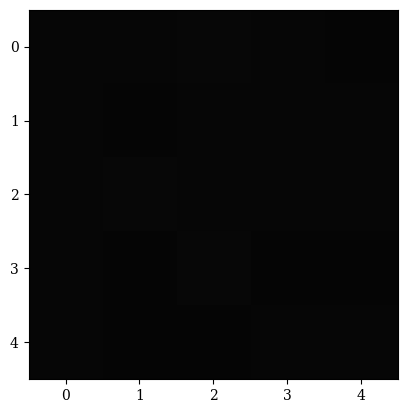

25.0

In [210]:
%matplotlib inline
plt.close()
blackPatch = sampleImg[50:55,10:15]
plt.imshow(blackPatch,cmap='gray',vmin=0,vmax=1024)
plt.show()
blackAve = np.round(np.average(blackPatch))
blackAve

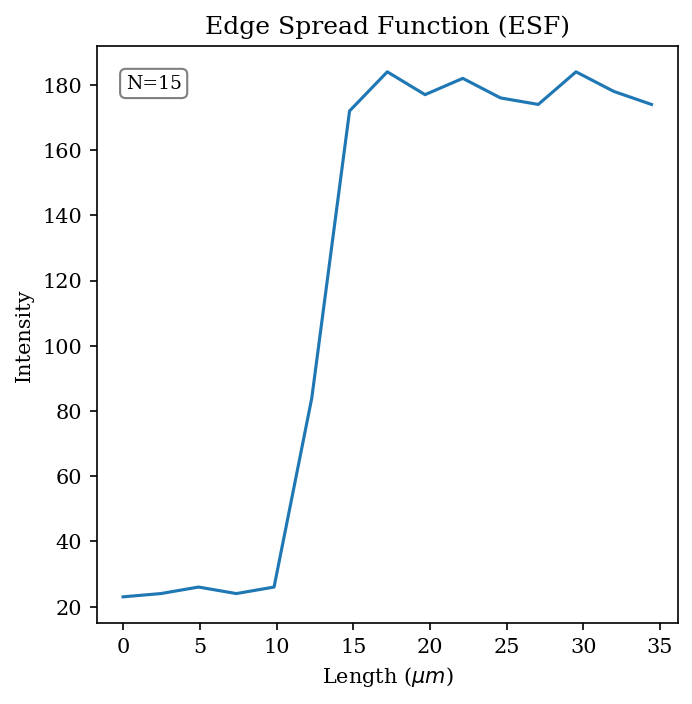

In [211]:
plt.close()
%matplotlib inline
ROI = sampleImg
fig, ax = plt.subplots(figsize=(5,5),dpi=150)


ESF = np.zeros((N,width))

i=3
row = ROI[x[i],y[i]:y[i]+width]
ESF[i] = row
ax.plot(d,row)

# Plot Parameters
ax.set_title('Edge Spread Function (ESF)')
ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
    verticalalignment='top', bbox=props)

# plt.savefig('ESF.png')
plt.show()

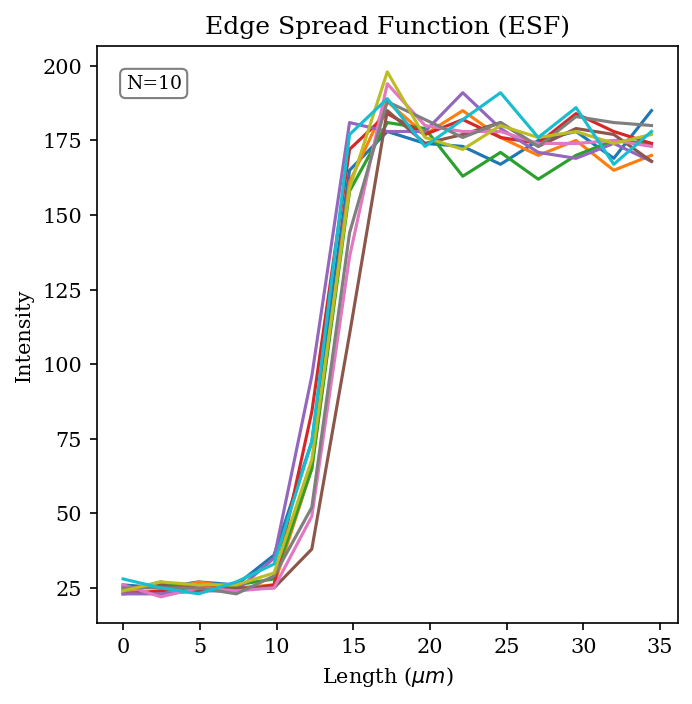

In [213]:
%matplotlib inline
plt.close()
ROI = sampleImg
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

N=10
ESF = np.zeros((N,width))

for i in range(N):
    row = ROI[x[i],y[i]:y[i]+width]
    ESF[i] = row
    ax.plot(d,row)


# Plot Parameters
ax.set_title('Edge Spread Function (ESF)')
ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
    verticalalignment='top', bbox=props)

# plt.savefig('ESF.png')
plt.show()

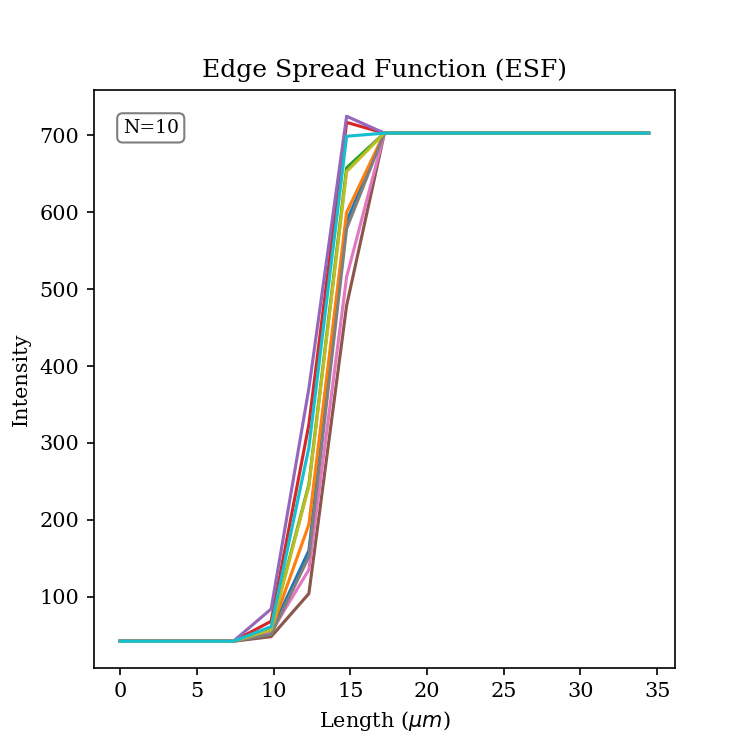

In [88]:
# %matplotlib widget
# plt.close()
# ROI = sampleImg
# fig, ax = plt.subplots(figsize=(5,5),dpi=150)

# ESF[:,7:] = bgAve 
# ESF[:,:4] = blackAve 

# for i in range(N):
#     ax.plot(d,ESF[i])


# # Plot Parameters
# ax.set_title('Edge Spread Function (ESF)')
# ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

# props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# # place a text box in upper left in axes coords
# ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
#     verticalalignment='top', bbox=props)

# # plt.savefig('ESF.png')
# plt.show()

In [23]:
np.max(ESF, axis=1)

array([703., 703., 703., 703., 703., 703., 703., 703., 703., 703.])

## 3. Obtain MTF

### Obtain Derivative to get the point spread function (PSF)


Text(0.05, 0.95, 'N=10')

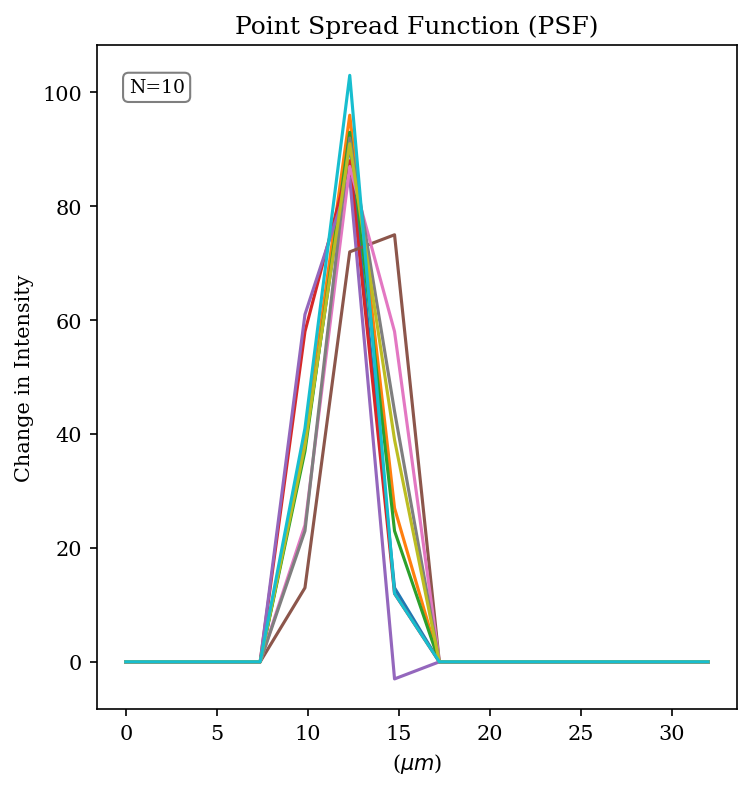

In [222]:
%matplotlib inline
plt.close()
derivative = np.diff(ESF, axis=1)
derivative[:,:4] = 0
derivative[:,7:] = 0

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
plt.tight_layout()

for row in derivative:
    ax.plot(d[:-1], row)


# Plot Parameters
ax.set_title("Point Spread Function (PSF)")
ax.set_xlabel("($\mu m$)")
ax.set_ylabel("Change in Intensity")

props = dict(boxstyle="round", facecolor="white", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.05,
    0.95,
    f"N={N}",
    transform=ax.transAxes,
    fontsize=9,
    verticalalignment="top",
    bbox=props,
)

# plt.savefig('PSF.png')

### Translate Units in Frequency Space

In the Fourier domain, the inverse of the smallest length interval $\Delta x$ determines the maximum frequency $F_\text{max}$.

$$F_\text{max} = \frac{1}{2\Delta x}$$

where the factor of two comes from dropping half of the fourier space. While the sampling window $L$ determines the resolution of the frequency space $\Delta f$ by

$$ \Delta f = \frac{1}{L}$$


In [223]:
# Translate units in frequency space
Fmax = 1 / (2 * scale) * 1000  # maximum frequency (lp/mm)
df = 1 / (width * scale) * 1000  # frequency resolution

# distances of samples in mm
f1 = np.linspace(0, Fmax, width // 2, endpoint=False)
f1.shape

(7,)

### Obtain Fourier Transform of PSF


Text(0.05, 0.1, 'N=10')

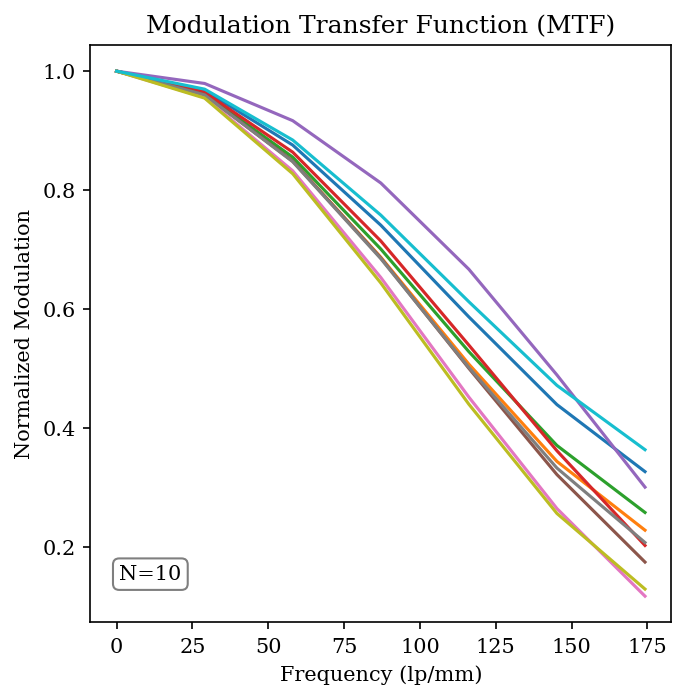

In [224]:
FT = fft(derivative, axis=1)
max_vals = np.max(np.abs(FT), axis=1)
MTF = (np.abs(FT) / max_vals[:, np.newaxis])[:, : width // 2]

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
for row in MTF:
    plt.plot(f1, row)


# Plot Parameters
ax.set_title("Modulation Transfer Function (MTF)")
ax.set_xlabel("Frequency (lp/mm)")
ax.set_ylabel("Normalized Modulation")

props = dict(boxstyle="round", facecolor="white", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.05,
    0.1,
    f"N={N}",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)
# plt.savefig('MTF.png')

### Average MTF


Text(0, 0.5, 'Normalized Modulation')

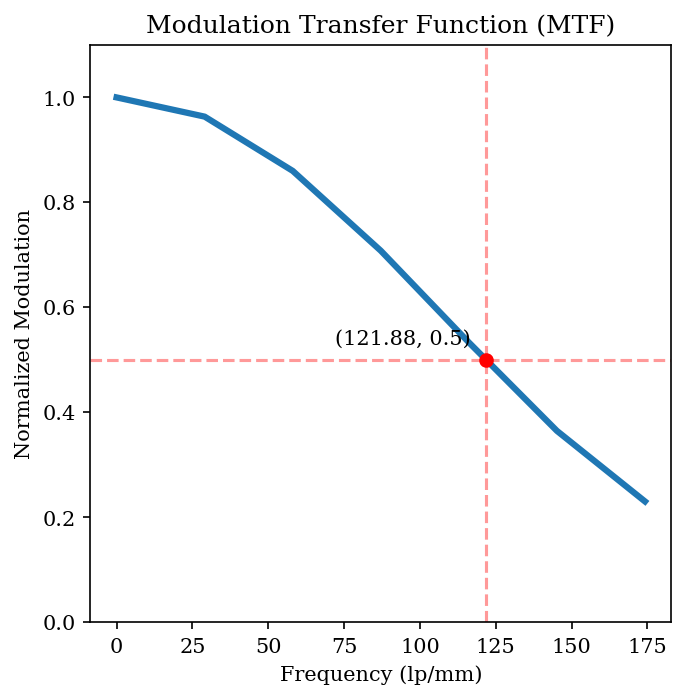

In [225]:
MTF_ave1 = np.average(MTF, axis=0)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

ax.plot(f1, MTF_ave1, linewidth=3)
ax.set_ylim(0, 1.1)

# Obtain half peak resolution
hpRes1 = interp1d(MTF_ave1, f1)(0.5)

# Plot Parameters
ax.axhline(0.5, color="red", linestyle="--", alpha=0.4)
ax.axvline(hpRes1, color="red", linestyle="--", alpha=0.4)
ax.plot(hpRes1, 0.5, color="red", marker="o")
ax.annotate(f"({hpRes1:.2f}, 0.5)", (hpRes1 - 50, 0.53))

ax.set_title("Modulation Transfer Function (MTF)")
ax.set_xlabel("Frequency (lp/mm)")
ax.set_ylabel("Normalized Modulation")

# plt.savefig('Average_MTF.png')

# Reconstruction MTF


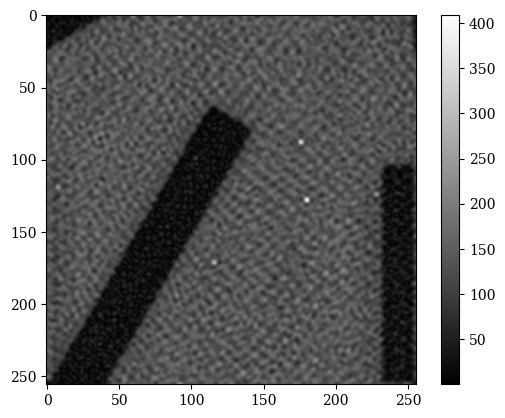

In [226]:
%matplotlib inline
plt.close()

# Load the .mat file containing the MATLAB array
# slantedReconstruction = np.load("Results temp/slanted Reconstruction(Dot matrix).npy")
slantedReconstruction = np.load("Results temp/slanted Reconstruction(Panel matrix).npy")

plt.imshow(slantedReconstruction, cmap="gray")
plt.colorbar()
plt.show()

## 1. Obtain Edge Spread Function (ESF)

### Obtain ROI

corner point [450,400]
ROI [103:123,84:74]


In [249]:
# Panel matrix point
x0 = 23
y0 = 27

N = 5

x = (np.round(np.arange(x0, N+x0)*2) - 20) * 4
y = (np.int8(-0.4 * np.arange(0, 3*N,3)) + y0) * 4
print(x)
print(y)

[104 112 120 128 136]
[108 104 100  96  92]


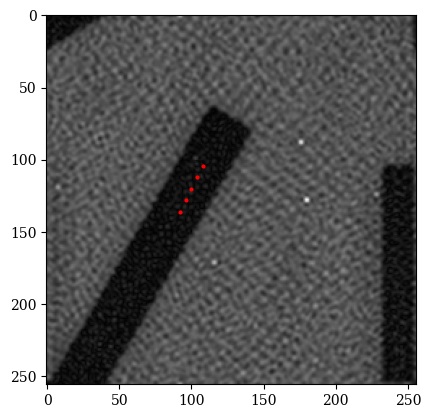

In [250]:
%matplotlib inline
plt.close()

plt.imshow(slantedReconstruction, cmap='gray')
plt.plot(y,x,'ro',markersize=2)
plt.show()

138.0

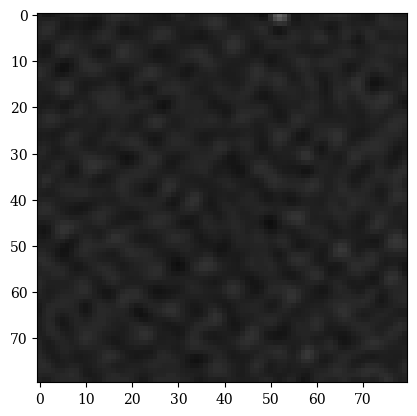

In [251]:
%matplotlib inline
plt.close()

# 7x7 Dot matrix
bgPatch = slantedReconstruction[32*4:52*4,32*4:52*4]

# 7x7 Panel matrix
# bgPatch = slantedReconstruction[60*4:100*4,60*4:100*4]

plt.imshow(bgPatch,cmap='gray',vmin=0,vmax=1024)
bgAve = np.round(np.average(bgPatch))
bgAve

27.0

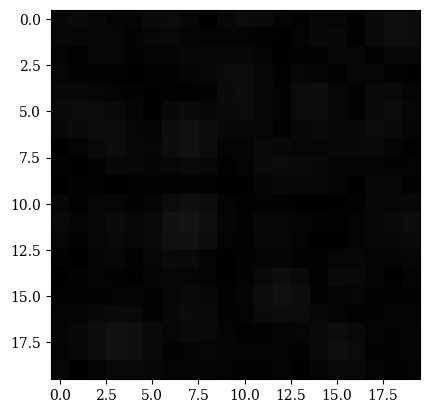

In [252]:
%matplotlib inline
plt.close()

# 7x7 Dot matrix
blackPatch = slantedReconstruction[50*4:55*4,10*4:15*4]

# 7x7 Panel matrix
# blackPatch = slantedReconstruction[87*4:94*4,83*4:90*4]

plt.imshow(blackPatch,cmap='gray',vmin=0,vmax=1024)
blackAve = np.round(np.average(blackPatch))
blackAve

### Image Scale

**4x Magnification 0.10 NA**

1px:2.51um


In [253]:
# Obtain real-world units
# width = 15 * 4
width = 30 * 4
scale = 2.46 / 4  # in microns/px
# distances of samples in mm
d = np.linspace(0, width * scale, width, endpoint=False)
d.shape

(120,)

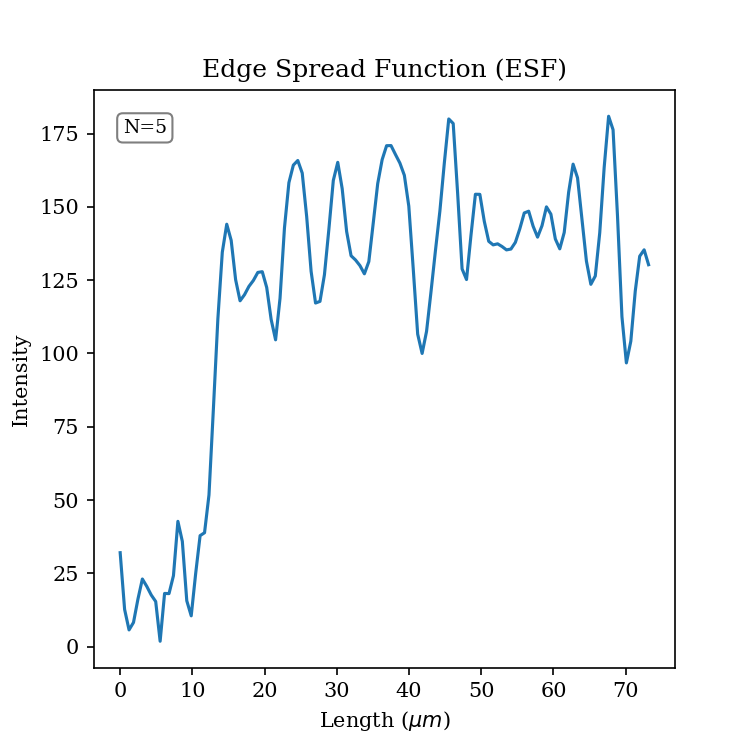

In [254]:
plt.close()
%matplotlib widget
ROI = slantedReconstruction
fig, ax = plt.subplots(figsize=(5,5),dpi=150)


ESF = np.zeros((N,width))

i=0
row = ROI[x[i],y[i]:y[i]+width]
ESF[i] = row
ax.plot(d,row)

# Plot Parameters
ax.set_title('Edge Spread Function (ESF)')
ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
    verticalalignment='top', bbox=props)

# plt.savefig('ESF.png')
plt.show()

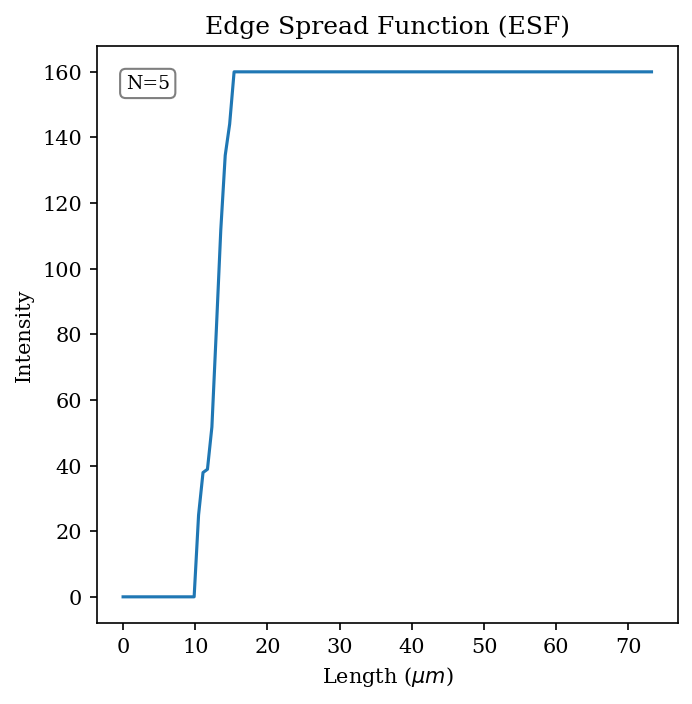

In [260]:
plt.close()
%matplotlib inline
ROI = slantedReconstruction
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

i=0
row = ROI[x[i],y[i]:y[i]+width]
ESF[i] = row

# Dot matrix
# ESF[:,39:] = 590
# ESF[:,:17] = 0

# Panel matrix
ESF[:,25:] = 160
ESF[:,:17] = 0

ax.plot(d,ESF[i])

# Plot Parameters
ax.set_title('Edge Spread Function (ESF)')
ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
    verticalalignment='top', bbox=props)

# plt.savefig('ESF.png')
plt.show()

## Many ESFs


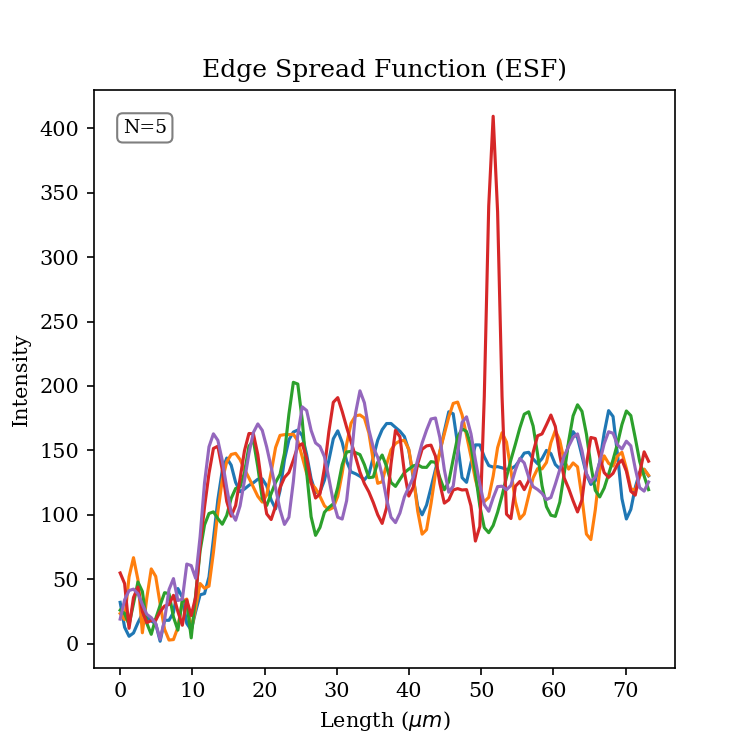

In [261]:
%matplotlib widget
plt.close()

ROI = slantedReconstruction
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

ESF = np.zeros((N,width))

for i in range(N):
    row = ROI[x[i],y[i]:y[i]+width]
    ESF[i] = row
    ax.plot(d,row)

# Plot Parameters
ax.set_title('Edge Spread Function (ESF)')
ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
    verticalalignment='top', bbox=props)

# plt.savefig('ESF.png')
plt.show()

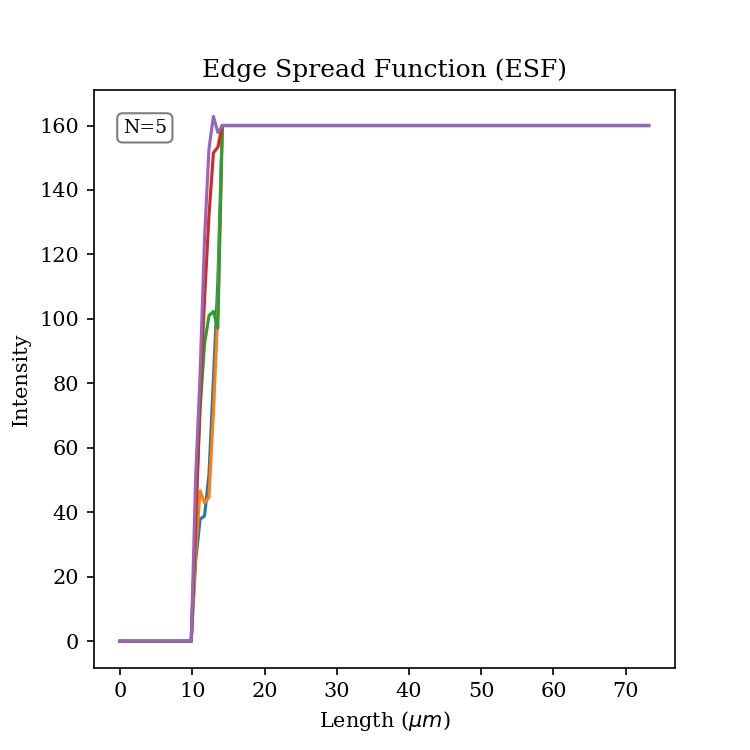

In [294]:
%matplotlib widget
plt.close()
ROI = slantedReconstruction
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

# Dot matrix
# ESF[:,39:] = 590
# ESF[:,:17] = 0

# Panel matrix
ESF[:,23:] = 160
ESF[:,:17] = 0

for i in range(N):
    ax.plot(d,ESF[i])


# Plot Parameters
ax.set_title('Edge Spread Function (ESF)')
ax.set_xlabel('Length ($\mu m$)'); ax.set_ylabel('Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
    verticalalignment='top', bbox=props)

# plt.savefig('ESF.png')
plt.show()

## 3. Obtain MTF

### Obtain Derivative to get the point spread function (PSF)


Text(0.05, 0.95, 'N=5')

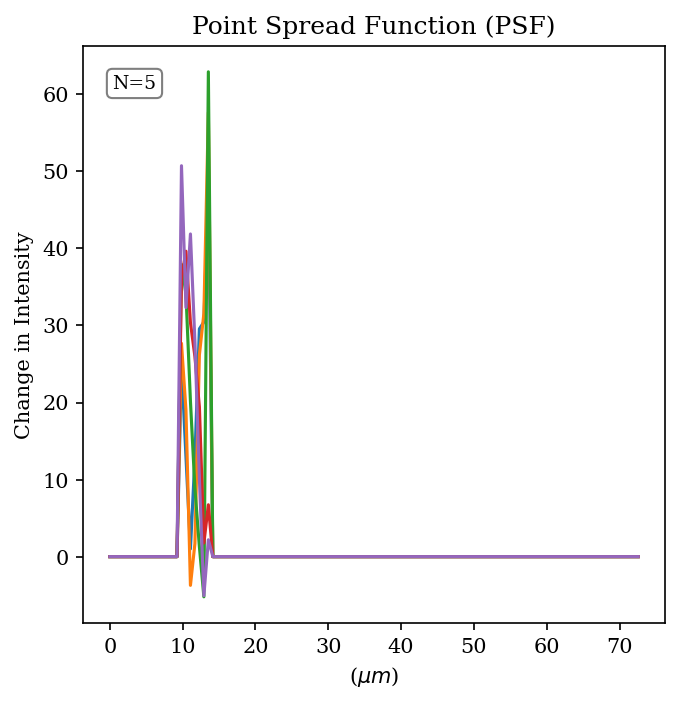

In [296]:
%matplotlib inline
plt.close()

# derivative = np.diff(ESF[8])
derivative = np.diff(ESF, axis=1)
derivative[:,24:] = 0

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
# ax.plot(d[:-1],derivative)

for row in derivative:
    ax.plot(d[:-1], row)


# Plot Parameters
ax.set_title('Point Spread Function (PSF)')
ax.set_xlabel('($\mu m$)')
ax.set_ylabel('Change in Intensity')

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, f'N={N}', transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# plt.savefig('PSF.png')

### Translate Units in Frequency Space

In the Fourier domain, the inverse of the smallest length interval $\Delta x$ determines the maximum frequency $F_\text{max}$.

$$F_\text{max} = \frac{1}{2\Delta x}$$

where the factor of two comes from dropping half of the fourier space. While the sampling window $L$ determines the resolution of the frequency space $\Delta f$ by

$$ \Delta f = \frac{1}{L}$$


In [297]:
# Translate units in frequency space
Fmax = 1 / (2 * scale) * 1000  # maximum frequency (lp/mm)
df = 1 / (width * scale)  # frequency resolution

# distances of samples in mm
f2 = np.linspace(0, Fmax, width // 2, endpoint=False)
f2.shape

(60,)

### Obtain Fourier Transform of PSF


Text(0.05, 0.1, 'N=5')

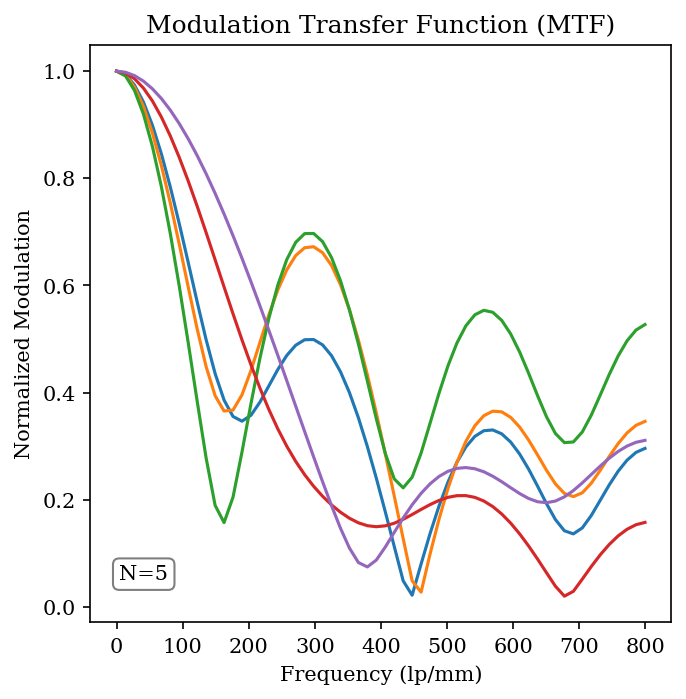

In [298]:
# FT = fft(derivative)
# max_vals = np.max(abs(FT))
# MTF = (abs(FT) / max_vals)[ : width // 2]

FT = fft(derivative, axis=1)
max_vals = np.max(abs(FT), axis=1)
MTF = (abs(FT) / max_vals[:, np.newaxis])[:, : width // 2]

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
# ax.plot(f2,MTF)

for row in MTF:
    ax.plot(f2, row)


# Plot Parameters
ax.set_title("Modulation Transfer Function (MTF)")
ax.set_xlabel("Frequency (lp/mm)")
ax.set_ylabel("Normalized Modulation")

props = dict(boxstyle="round", facecolor="white", alpha=0.5)

# place a text box in upper left in axes coords
ax.text(
    0.05,
    0.1,
    f"N={N}",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=props,
)
# plt.savefig('MTF.png')

### Average MTF


Text(0, 0.5, 'Normalized Modulation')

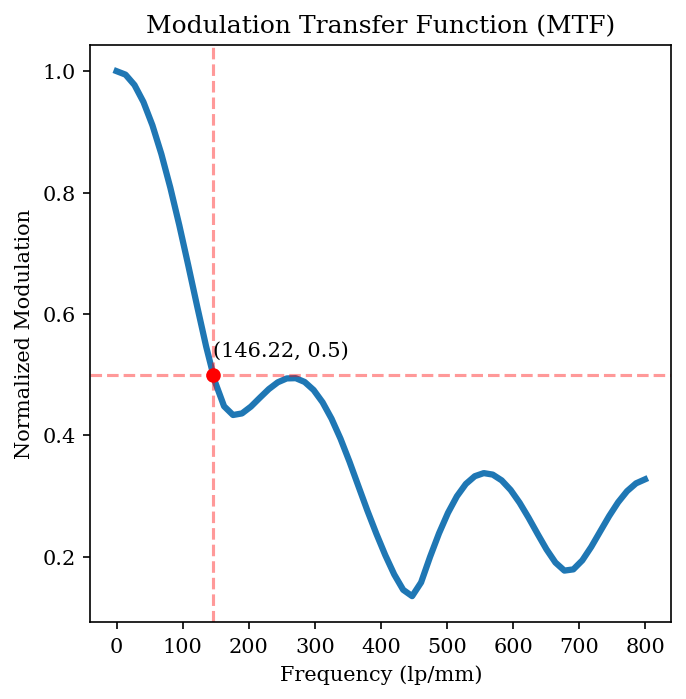

In [303]:
%matplotlib inline
plt.close()

MTF_ave2 = np.average(MTF, axis=0)

fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

ax.plot(f2, MTF_ave2, linewidth=3)

# Obtain half peak resolution
hpRes2 = interp1d(MTF_ave2[:15], f2[:15])(0.5)

# Plot Parameters
ax.axhline(0.5, color='red', linestyle='--', alpha=0.4)
ax.axvline(hpRes2, color='red', linestyle='--', alpha=0.4)
ax.plot(hpRes2, 0.5, color='red', marker='o')
ax.annotate(f"({hpRes2:.2f}, 0.5)", (hpRes2, 0.53))

ax.set_title('Modulation Transfer Function (MTF)')
ax.set_xlabel('Frequency (lp/mm)')
ax.set_ylabel('Normalized Modulation')

# plt.savefig('Average_MTF.png')

# MTF Comparison


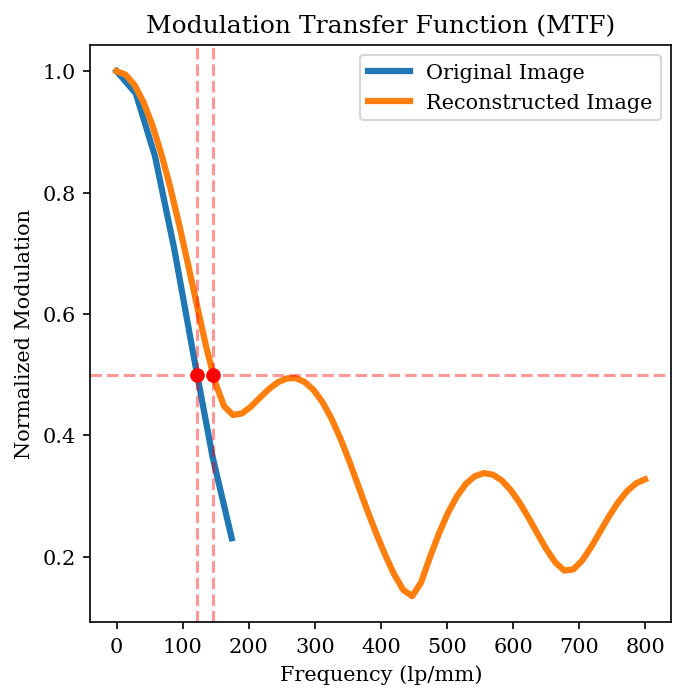

In [305]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

ax.plot(f1, MTF_ave1, linewidth=3, label="Original Image")
ax.plot(f2, MTF_ave2, linewidth=3, label="Reconstructed Image")

# Plot Parameters
ax.axhline(0.5, color="red", linestyle="--", alpha=0.4)
ax.axvline(hpRes1, color="red", linestyle="--", alpha=0.4)
ax.axvline(hpRes2, color="red", linestyle="--", alpha=0.4)
ax.plot(hpRes1, 0.5, color="red", marker="o")
ax.plot(hpRes2, 0.5, color="red", marker="o")

ax.set_title("Modulation Transfer Function (MTF)")
ax.set_xlabel("Frequency (lp/mm)")
ax.set_ylabel("Normalized Modulation")
plt.legend()

# plt.savefig('Average_MTF.png')

In [306]:
np.savez(
    "Results temp/panel matrix MTF.npz", f1=f1, MTF1=MTF_ave1, f2=f2, MTF2=MTF_ave2
)